# RGB Training Example

In [1]:
import os; os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.5"
import io, time, torch, datasets, PIL.Image, numpy as np, matplotlib.pyplot as plt, fastprogress, IPython.display
from einops.layers.torch import Rearrange
from types import SimpleNamespace
from typing import OrderedDict
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from torchvision.transforms import Compose, Resize, RandomCrop, CenterCrop, ColorJitter
from livecodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from timm.optim import Adan

In [2]:
device = 'cuda:3'
dataset = datasets.DatasetDict({
    'train': datasets.load_dataset("danjacobellis/LSDIR",split='train'),
    'validation': datasets.load_dataset("danjacobellis/kodak",split='validation')
})
config = SimpleNamespace()
config.F = 16
config.latent_dim = 192
config.input_channels = 3
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.epochs = 150
config.batch_size = 4
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.min_aspect = 0.5
config.max_aspect = 2
config.min_size = 240
config.max_size = 640
config.min_scale = 1.0
config.max_scale = 2.0
config.max_lr = 3e-4
config.min_lr = 1e-8
config.lr_pow = 2
config.num_workers = 12
config.save_checkpoint_name = 'f16c192.pth'

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [3]:
model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

optimizer = Adan(model.parameters(), lr=1.0)
def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)
print(sum(p.numel() for p in model.parameters())/1e6)

76.600512


In [4]:
def train_collate_fn(batch):
    aspect = np.random.uniform(config.min_aspect,config.max_aspect)
    h = np.random.uniform(config.min_size,config.max_size); w = h*aspect;
    h = int((config.F*(np.rint(h/config.F))).clip(config.min_size,config.max_size))
    w = int((config.F*(np.rint(w/config.F))).clip(config.min_size,config.max_size))
    x = []
    for i_sample, sample in enumerate(batch):
        transform = Compose([
            Resize(
                int(max(h,w)*np.random.uniform(config.min_scale,config.max_scale)),
                interpolation=PIL.Image.Resampling.BICUBIC,
                max_size=1+int(config.max_scale*config.max_size)
            ),
            RandomCrop((h,w),pad_if_needed=True,padding_mode='symmetric'),
            ColorJitter(0.4,0.0,0.4,0.0),
        ])
        xi = pil_to_tensor(transform(sample['image'].convert("RGB"))).unsqueeze(0)
        x.append(xi)
    x = torch.cat(x)
    return x.to(torch.float)/127.5 - 1.0

def enc_dec(sample):
    img = sample['image']
    buff = io.BytesIO()
    x = pil_to_tensor(img).to(torch.float).to(device).unsqueeze(0)/127.5 - 1.0
    t0 = time.time()
    with torch.inference_mode():
        z = model.encode(x)
        z = model.quantize.compand(z).round()
    latent_to_pil(z.cpu().detach(),n_bits=8,C=3)[0].save(buff, format='WEBP', lossless=True)
    enc_time = time.time() - t0
    size_bytes = len(buff.getbuffer())
    t0 = time.time()
    z = pil_to_latent([PIL.Image.open(buff)],N=config.latent_dim,n_bits=8,C=3).to(device)
    with torch.inference_mode():
        xhat = model.decode(z).clamp(-1,1)
    dec_time = time.time() - t0
    x_01 = x/2 + 0.5
    xhat_01 = xhat/2 + 0.5
    psnr = -10*torch.nn.functional.mse_loss(x_01, xhat_01).log10().item()
    del sample['path']
    del sample['image']
    return{
        'psnr': psnr,
        'cr': x.numel()/size_bytes,
        'enc': (x.numel()/3e6)/enc_time,
        'dec': (x.numel()/3e6)/dec_time
    }

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = fastprogress.master_bar(range(config.epochs))
log_mse_losses = []
rate_losses = []
valid_metrics = []
global_step = 0
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=train_collate_fn
        )
    pb = fastprogress.progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        log_mse_losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*log_mse_losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    valid = dataset['validation'].map(enc_dec)
    valid_metrics.append({key: torch.tensor(valid[key]).mean().item() for key in valid.features.keys()})
    mb.main_bar.comment = ";  ".join([f'{key}: {valid_metrics[-1][key]:0.4g}' for key in valid_metrics[-1]])
    
    torch.save({
        'i_epoch': i_epoch,
        'log_mse_losses': log_mse_losses,
        'learning_rates': learning_rates,
        'valid_metrics': {k: [d[k] for d in valid_metrics] for k in valid_metrics[0].keys()},
        'config': config,
        'state_dict': model.state_dict()
    }, config.save_checkpoint_name)

(-4.0, -2.0)

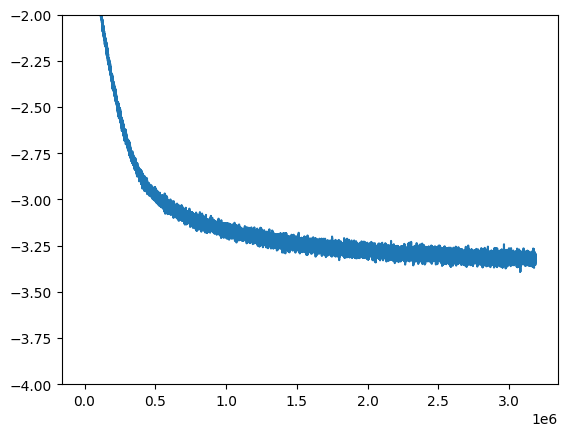

In [6]:
display(IPython.display.HTML(mb.main_bar.progress))
display(IPython.display.HTML(pb.progress))
N = 501; plt.plot(np.convolve(log_mse_losses, N*[1/N], mode='valid'))
plt.ylim([-4,-2])

In [7]:
torch.tensor(([[v[key] for key in v.keys()] for v in valid_metrics]))[-1]

tensor([40.2877,  6.1643, 11.1858, 41.7690])

In [ ]:
torch.save({
    'valid_metrics': {k: [d[k] for d in valid_metrics] for k in valid_metrics[0].keys()},
    'config': config,
    'state_dict': model.state_dict()
}, '../../../hf/liveaction/lsdir_f16c192.pth')